In [1]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530

# 폴더 경로
submission_folder = '/home/user/torch_ubuntu/lifelog-sleep-ictc-2025/minjeong/submission/'

# 파일명에 타임스탬프 추가
submission_file = f'submission_final_mod2_1_{timestamp}.csv'


In [2]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf


2025-05-17 23:10:36.326139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 23:10:36.344052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747491036.358656   11996 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747491036.363698   11996 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747491036.375655   11996 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/home/user/torch_ubuntu/src/data/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [4]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [5]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [6]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [7]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [8]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [9]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

In [10]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [11]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


In [12]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                if str(device['device_class']) == '0': 
                    class_0_cnt += 1 
                else: 
                    class_other_cnt += 1 
            except: 
                continue # malformed record 
        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features) 

In [13]:
def summarize_mBle_daily(df): 
    # row 단위 BLE feature 추출 
    df = process_mBle(df) 
    # 하루 단위로 cnt 합치기 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    # 총합 구해서 비율 계산 
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] 
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    # 필요 없는 원래 cnt 컬럼 제거 
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True) 
    return grouped 

mBle_df2 = summarize_mBle_daily(mBle_df) 

In [14]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [15]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

In [16]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [17]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0, 
        }) 
    return pd.DataFrame(features) 

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [18]:
top_apps = [ 
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
    '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
] 

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [19]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 

In [20]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

In [21]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [22]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

In [23]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2, 
    mAmbience_df2, 
    mBle_df2, 
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, 
    mUsageStats_df2, 
    mWifi_df2, 
    wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [24]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [25]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [26]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 

In [27]:
# 결과 저장 
# 그룹별 중요 특성 선택
important_features = [
    # 스크린 관련 특성
    'screen_on_ratio', 'screen_on_duration_avg', 'screen_on_duration_max',
    
    # 와이파이 신호 관련 특성
    'wifi_rssi_max', 'wifi_rssi_mean', 'wifi_detected_cnt',
    
    # 활동 관련 특성
    'activity_3_ratio', 'activity_4_ratio',
    
    # 충전 관련 특성
    'charging_ratio', 'max_charging_duration', 'avg_charging_duration',
    
    # 신호 관련 특성
    'rssi_mean',
    
    # 빛 관련 특성
    'light_night_mean', 'light_max', 'light_std',
    
    # 위치/움직임 관련 특성
    'altitude_mean', 'speed_max_x',
    
    # 앱 사용 관련 특성
    '메시지_time', 'others_time', 'Narration_monologue'
]

# 선택된 특성만으로 데이터셋 구성
X_selected = X[important_features]
test_X_selected = test_X[important_features]


# # TabNet 공통 파라미터 설정 (1차)
# tabnet_params = {
#     'optimizer_fn': torch.optim.Adam,
#     'optimizer_params': dict(lr=0.02),
#     'scheduler_params': {"step_size":10, "gamma":0.9},
#     'scheduler_fn': torch.optim.lr_scheduler.StepLR,
#     'mask_type': 'entmax',
#     'n_d': 64,  # 결정 단계의 차원
#     'n_a': 64,  # 주의 단계의 차원
#     'n_steps': 5,  # 결정 단계의 수
#     'gamma': 1.5,  # 특성 선택 정규화 매개변수
#     'lambda_sparse': 1e-3,  # 희소성 정규화
#     # 'max_epochs': 100, 
#     # 'patience': 10,
#     # 'batch_size': 256,
#     # 'virtual_batch_size': 128
# }

# TabNet 공통 파라미터 설정
tabnet_params = {
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=0.005),  # 학습률 낮춤 (0.02 -> 0.005)
    'scheduler_params': {"step_size":50, "gamma":0.95},  # 학습률 감소 덜 공격적으로
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'mask_type': 'entmax',
    'n_d': 32,  # 더 간단한 모델 (64 -> 32)
    'n_a': 32,  # 더 간단한 모델 (64 -> 32)
    'n_steps': 3,  # 단계 수 감소 (5 -> 3)
    'gamma': 1.3,  # 정규화 파라미터 약화 (1.5 -> 1.3)
    'lambda_sparse': 1e-4,  # 희소성 정규화 약화 (1e-3 -> 1e-4)

} 

In [30]:
# TabNet 모델 import
from pytorch_tabnet.tab_model import TabNetClassifier
import torch



# 선택된 특성으로 모델 훈련
# 이진 분류
binary_preds_selected = {}
for col in targets_binary:
    y = train_df[col]
    
    # TabNetClassifier 초기화
    model = TabNetClassifier(**tabnet_params)
    
    # 모델 학습
    model.fit(
        X_selected.values,  # 첫 번째 인자: X_train
        y,                  # 두 번째 인자: y_train
        eval_set=[(X_selected.values, y)], # 검증 세트를 별도로 분리하는 것이 좋습니다
        eval_metric=['auc'],
        # (1차)
        # max_epochs=100 , # 여기에 max_epochs 추가 ,
        # patience=10,     # 조기 종료 인내
        # batch_size=256,  # 배치 크기
        # virtual_batch_size=128  # 가상 배치 크기

        # (2차)
        max_epochs=200,  # 에포크 수 증가
        patience=15,  # 조기 종료 인내심 증가
        batch_size=1024,  # 배치 크기 증가 (더 안정적인 학습)
        virtual_batch_size=256,  # 가상 배치 크기 증가
    )
    
    # 예측 (predict_proba로 확률 반환, class 1의 확률만 사용)
    probs = model.predict_proba(test_X_selected.values)
    binary_preds_selected[col] = (probs[:, 1] > 0.5).astype(int)  # 0.5 임계값 적용
    
    # 또는 바로 클래스 예측
    # binary_preds_selected[col] = model.predict(test_X_selected)

# 다중 분류 (S1)
y_multi = train_df['S1'].values  # DataFrame 열을 NumPy 배열로 변환

# TabNetClassifier 초기화
model_s1_selected = TabNetClassifier(**tabnet_params)
 
# 모델 학습
model_s1_selected.fit(
    X_selected.values,  # X_train: NumPy 배열
    y_multi,            # y_train: NumPy 배열
    eval_set=[(X_selected.values, y_multi)],  # 모든 데이터를 NumPy 배열로
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

# 예측 (predict 메서드에도 NumPy 배열 전달)
multiclass_pred_selected = model_s1_selected.predict(test_X_selected.values)

epoch 0  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 11 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 12 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 13 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 14 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s
epoch 15 | loss: 0.0     | val_0_auc: 0.49856 |  0:00:00s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

In [29]:
# # 선택된 특성으로 모델 훈련
# # 이진 분류
# binary_preds_selected = {}
# for col in targets_binary:
#     y = train_df[col]
#     model = RandomForestClassifier(**common_params)
#     model.fit(X_selected, y)
#     binary_preds_selected[col] = model.predict(test_X_selected)

# # 다중 분류 (S1)
# y_multi = train_df['S1']
# model_s1_selected = RandomForestClassifier(**common_params)
# model_s1_selected.fit(X_selected, y_multi)
# multiclass_pred_selected = model_s1_selected.predict(test_X_selected)

In [31]:
# 성능 평가 (원본 모델과 비교)
# 검증 데이터 분할

# 모델 평가 (검증 데이터가 있는 경우)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# X_selected와 y_multi가 DataFrame인 경우를 대비하여 NumPy 배열로 변환
X_selected_numpy = X_selected.values if hasattr(X_selected, 'values') else X_selected
y_multi_numpy = y_multi.values if hasattr(y_multi, 'values') else y_multi

X_train_sel, X_val_sel, y_train, y_val = train_test_split(
    X_selected_numpy, y_multi_numpy, test_size=0.2, random_state=42, stratify=y_multi_numpy
)

# 평가용 모델 학습
eval_model_sel = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

# 추가 훈련 매개변수들을 fit 메서드에 직접 전달
eval_model_sel.fit(
    X_train_sel,  # 이미 NumPy 배열
    y_train,      # 이미 NumPy 배열
    eval_set=[(X_train_sel, y_train), (X_val_sel, y_val)],  # 검증 세트 추가
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

# 예측 및 평가
y_pred_sel = eval_model_sel.predict(X_val_sel)  # 이미 NumPy 배열

print("\n===== 그룹 기반 특성 선택 모델 평가 (S1) =====")
print(classification_report(y_val, y_pred_sel))

epoch 0  | loss: 1.36985 | val_0_accuracy: 0.32778 | val_1_accuracy: 0.32222 |  0:00:00s
epoch 1  | loss: 1.24027 | val_0_accuracy: 0.33611 | val_1_accuracy: 0.28889 |  0:00:00s
epoch 2  | loss: 1.12706 | val_0_accuracy: 0.31944 | val_1_accuracy: 0.26667 |  0:00:00s
epoch 3  | loss: 1.1575  | val_0_accuracy: 0.28889 | val_1_accuracy: 0.32222 |  0:00:00s
epoch 4  | loss: 1.07659 | val_0_accuracy: 0.33611 | val_1_accuracy: 0.34444 |  0:00:00s
epoch 5  | loss: 0.96087 | val_0_accuracy: 0.35    | val_1_accuracy: 0.35556 |  0:00:00s
epoch 6  | loss: 0.98821 | val_0_accuracy: 0.35278 | val_1_accuracy: 0.26667 |  0:00:00s
epoch 7  | loss: 1.06051 | val_0_accuracy: 0.35833 | val_1_accuracy: 0.34444 |  0:00:00s
epoch 8  | loss: 0.95354 | val_0_accuracy: 0.35556 | val_1_accuracy: 0.33333 |  0:00:00s
epoch 9  | loss: 0.95933 | val_0_accuracy: 0.37778 | val_1_accuracy: 0.36667 |  0:00:00s
epoch 10 | loss: 0.95225 | val_0_accuracy: 0.38889 | val_1_accuracy: 0.35556 |  0:00:00s
epoch 11 | loss: 0.92

In [32]:
# # 이진 분류 학습 
# for col in targets_binary: 
#     y = train_df[col] 
#     model = RandomForestClassifier(**common_params) 
#     model.fit(X, y) 
#     binary_preds[col] = model.predict(test_X) # 🔥 확률X, 클래스 직접 예측 

# # 다중 분류 학습 (S1) 
# y_multi = train_df['S1'] 
# model_s1 = RandomForestClassifier(**common_params) 
# model_s1.fit(X, y_multi) 
# multiclass_pred = model_s1.predict(test_X) # 🔥 클래스 직접 예측 

# # importance 출력
# feature_importance = pd.DataFrame({ 
#     'feature': X.columns, 
#     'importance': model_s1.feature_importances_ 
# }).sort_values('importance', ascending=False) 

# # 시각화 
# plt.figure(figsize=(10, 10)) 
# sns.barplot(x='importance', y='feature', data=feature_importance) 
# plt.title('Feature Importance')
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.show()

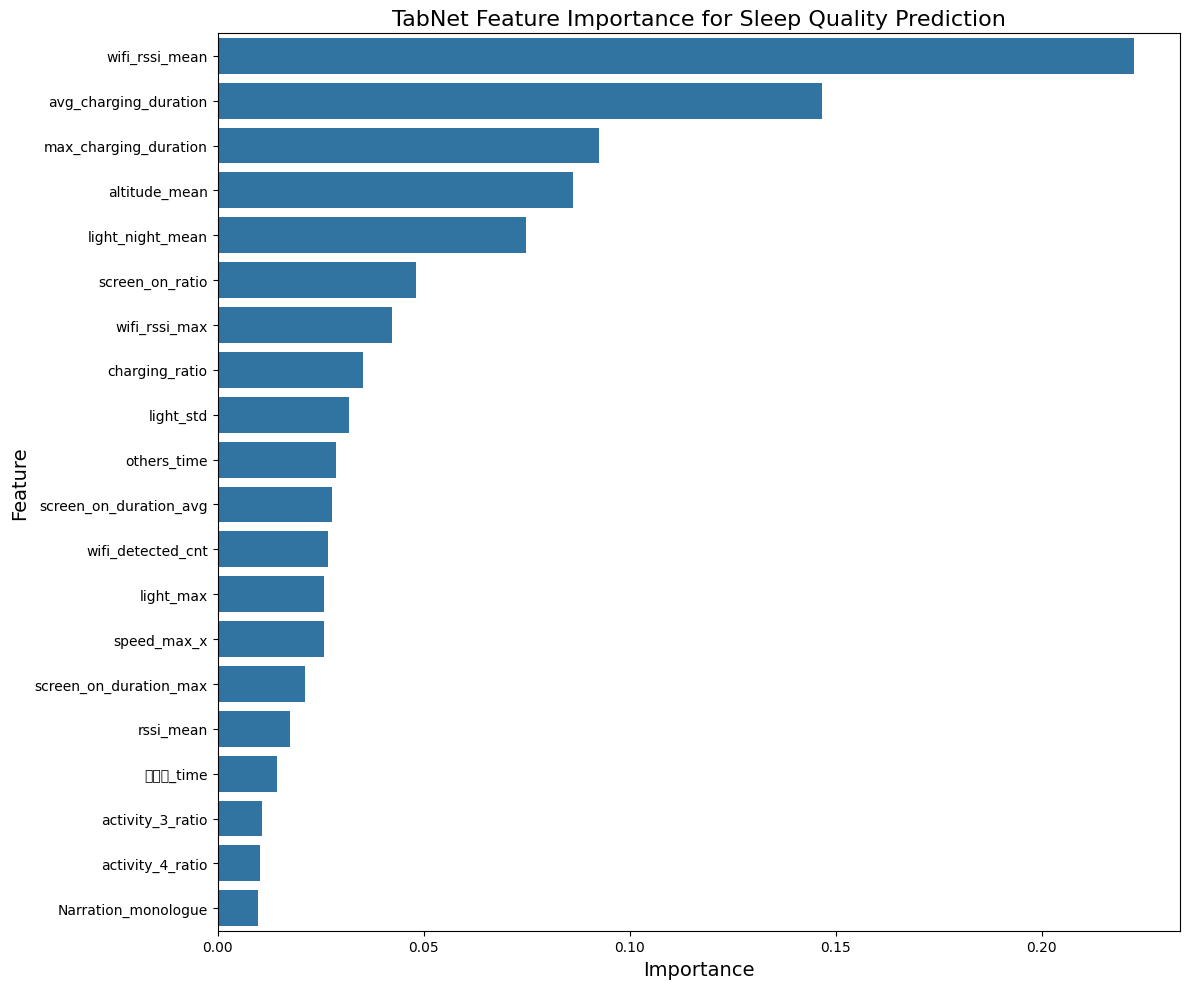


===== TabNet 모델 특성 중요도 (상위 20개) =====
                   feature  importance
4           wifi_rssi_mean    0.222457
10   avg_charging_duration    0.146752
9    max_charging_duration    0.092567
15           altitude_mean    0.086276
12        light_night_mean    0.074946
0          screen_on_ratio    0.048181
3            wifi_rssi_max    0.042263
8           charging_ratio    0.035270
14               light_std    0.031926
18             others_time    0.028822
1   screen_on_duration_avg    0.027868
5        wifi_detected_cnt    0.026725
13               light_max    0.025947
16             speed_max_x    0.025751
2   screen_on_duration_max    0.021233
11               rssi_mean    0.017684
17                메시지_time    0.014387
6         activity_3_ratio    0.010838
7         activity_4_ratio    0.010395
19     Narration_monologue    0.009714


In [43]:
# TabNetClassifier에 대한 feature importance 시각화 코드
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm

# # 한글 폰트 설정 (필요한 경우)
# # font_path = 'NanumGothic.ttf'  # 사용할 폰트 파일 경로
# # font_prop = fm.FontProperties(fname=font_path)
# # plt.rcParams['font.family'] = font_prop.get_name()
# plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용 가능한 한글 폰트
# plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 표시 오류 수정

def visualize_tabnet_feature_importance(model, feature_names, k, title="TabNet Feature Importance", figsize=(12, 10)):
    """
    TabNetClassifier 모델의 feature importance를 시각화합니다.
    
    Parameters:
    -----------
    model : TabNetClassifier
        학습된 TabNetClassifier 모델
    feature_names : list
        특성 이름 목록
    title : str, optional
        그래프 제목
    figsize : tuple, optional
        그래프 크기
    """
    # TabNetClassifier의 feature_importances_ 가져오기
    # 모델이 fit 메서드를 호출한 후에만 사용 가능
    if not hasattr(model, "feature_importances_"):
        print("Error: 모델이 학습되지 않았거나 feature_importances_가 계산되지 않았습니다.")
        return
    
    # TabNet의 특성 중요도 가져오기
    importances = model.feature_importances_
    
    # 특성 이름과 중요도 짝짓기
    if len(importances) != len(feature_names):
        print(f"Error: feature_importances_의 길이({len(importances)})와 feature_names의 길이({len(feature_names)})가 일치하지 않습니다.")
        return
    
    # 특성 중요도 데이터프레임 생성
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # 중요도 기준 내림차순 정렬
    feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
    
    # 시각화
    plt.figure(figsize=figsize)
    sns.barplot(x='importance', y='feature', data=feat_imp_df)
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    
    # 저장 및 표시
    plt.savefig(f'graph/tabnet_FI_for_{k}_{timestamp}.png', dpi=300)
    plt.show()
    
    return feat_imp_df

# 모델 학습 후, S1(다중 분류)에 대한 TabNetClassifier 모델의 특성 중요도 시각화
# model_s1_selected는 S1 예측을 위한 학습된 TabNetClassifier 모델
feature_importance_df = visualize_tabnet_feature_importance(
    model=model_s1_selected,  # S1에 대한 TabNet 모델
    feature_names=X_selected.columns.tolist(),  # 선택된 특성의 이름 목록
    k = "Sleep Quality Prediction",
    title=f"TabNet Feature Importance for Sleep Quality Prediction"
)

# 상위 20개 특성 중요도 출력
print("\n===== TabNet 모델 특성 중요도 (상위 20개) =====")
print(feature_importance_df.head(20))

epoch 0  | loss: 0.74196 | val_0_auc: 0.51518 |  0:00:00s
epoch 1  | loss: 0.75512 | val_0_auc: 0.51625 |  0:00:00s
epoch 2  | loss: 0.7282  | val_0_auc: 0.50785 |  0:00:00s
epoch 3  | loss: 0.77659 | val_0_auc: 0.48511 |  0:00:00s
epoch 4  | loss: 0.64226 | val_0_auc: 0.46256 |  0:00:00s
epoch 5  | loss: 0.67667 | val_0_auc: 0.47647 |  0:00:00s
epoch 6  | loss: 0.69333 | val_0_auc: 0.4202  |  0:00:00s
epoch 7  | loss: 0.6792  | val_0_auc: 0.4542  |  0:00:01s
epoch 8  | loss: 0.66474 | val_0_auc: 0.46939 |  0:00:01s
epoch 9  | loss: 0.67662 | val_0_auc: 0.4693  |  0:00:02s
epoch 10 | loss: 0.68464 | val_0_auc: 0.49018 |  0:00:02s
epoch 11 | loss: 0.63795 | val_0_auc: 0.51036 |  0:00:02s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.51625
epoch 0  | loss: 0.76707 | val_0_auc: 0.47851 |  0:00:00s
epoch 1  | loss: 0.71353 | val_0_auc: 0.51539 |  0:00:00s
epoch 2  | loss: 0.67964 | val_0_auc: 0.49397 |  0:00:00s
epoch 3  | loss: 0.66631 | val_0_auc: 0.4664

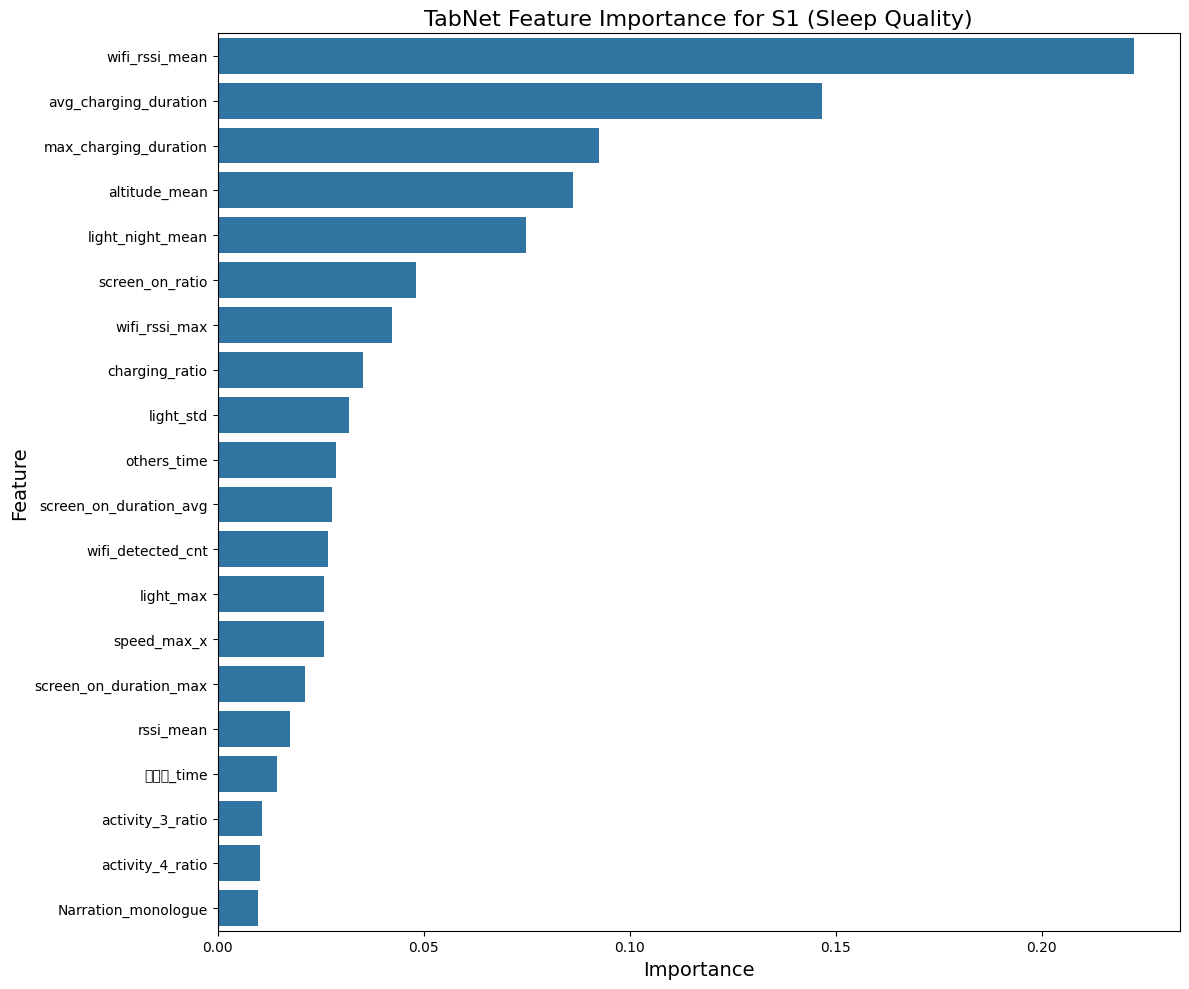

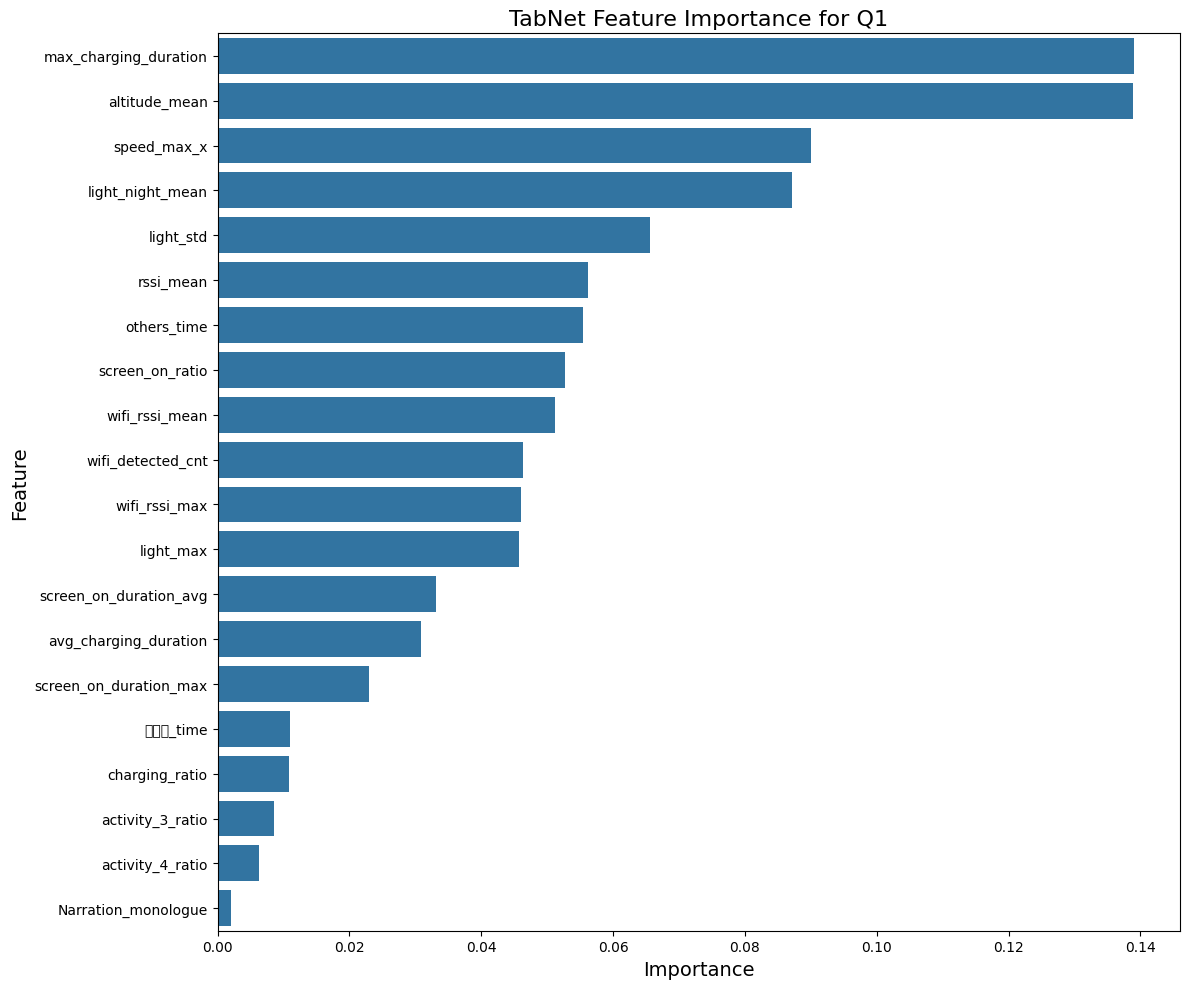

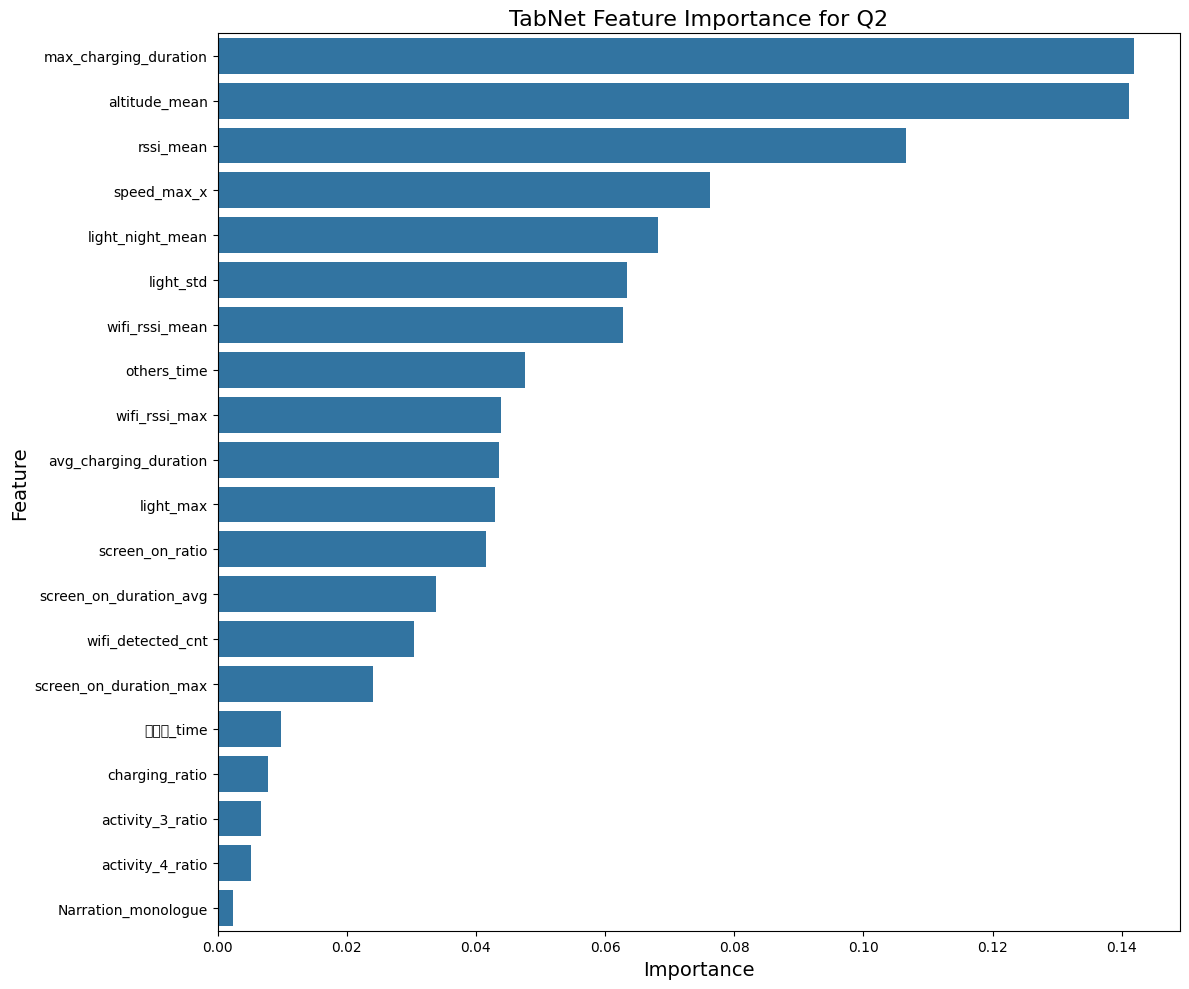

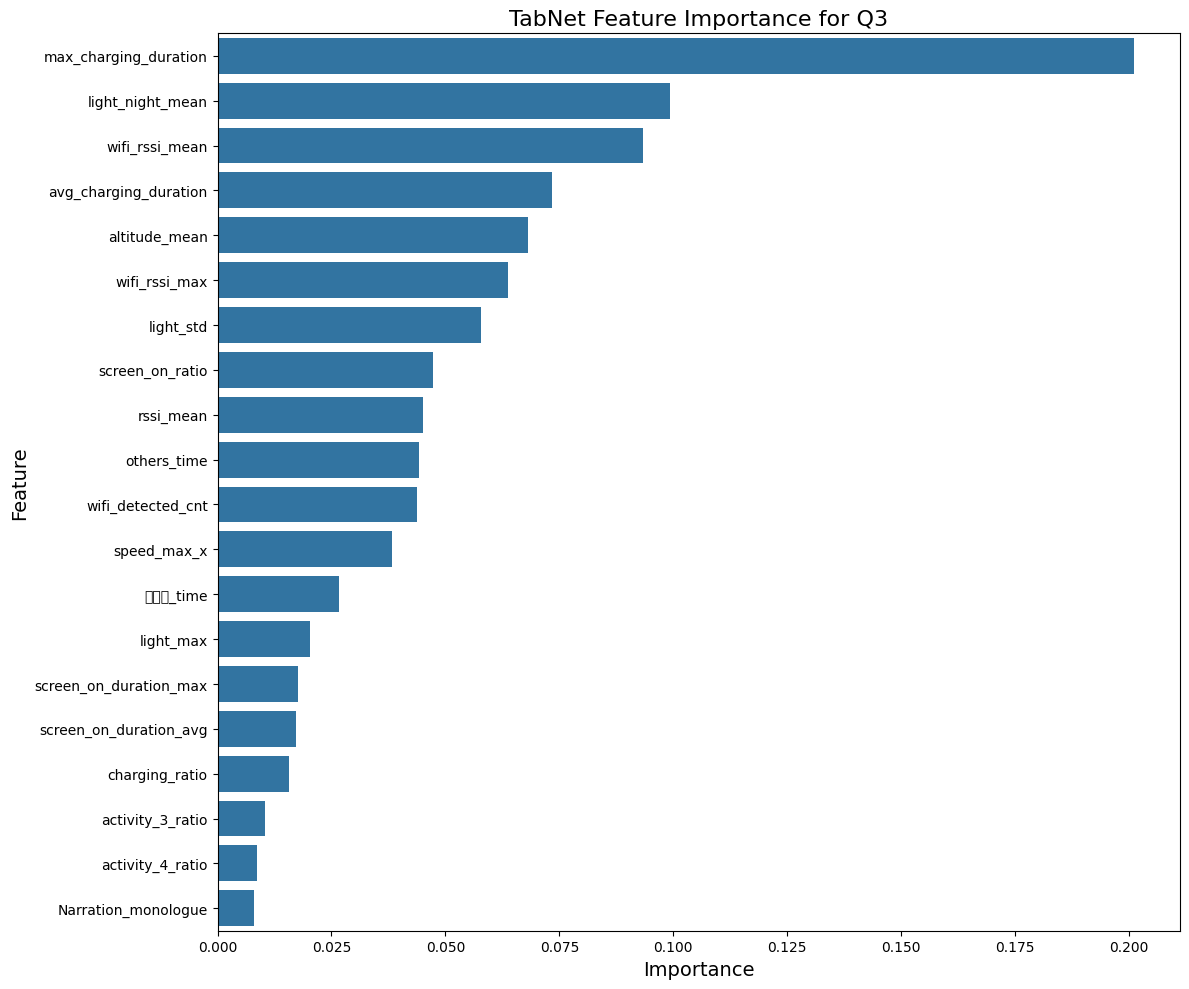

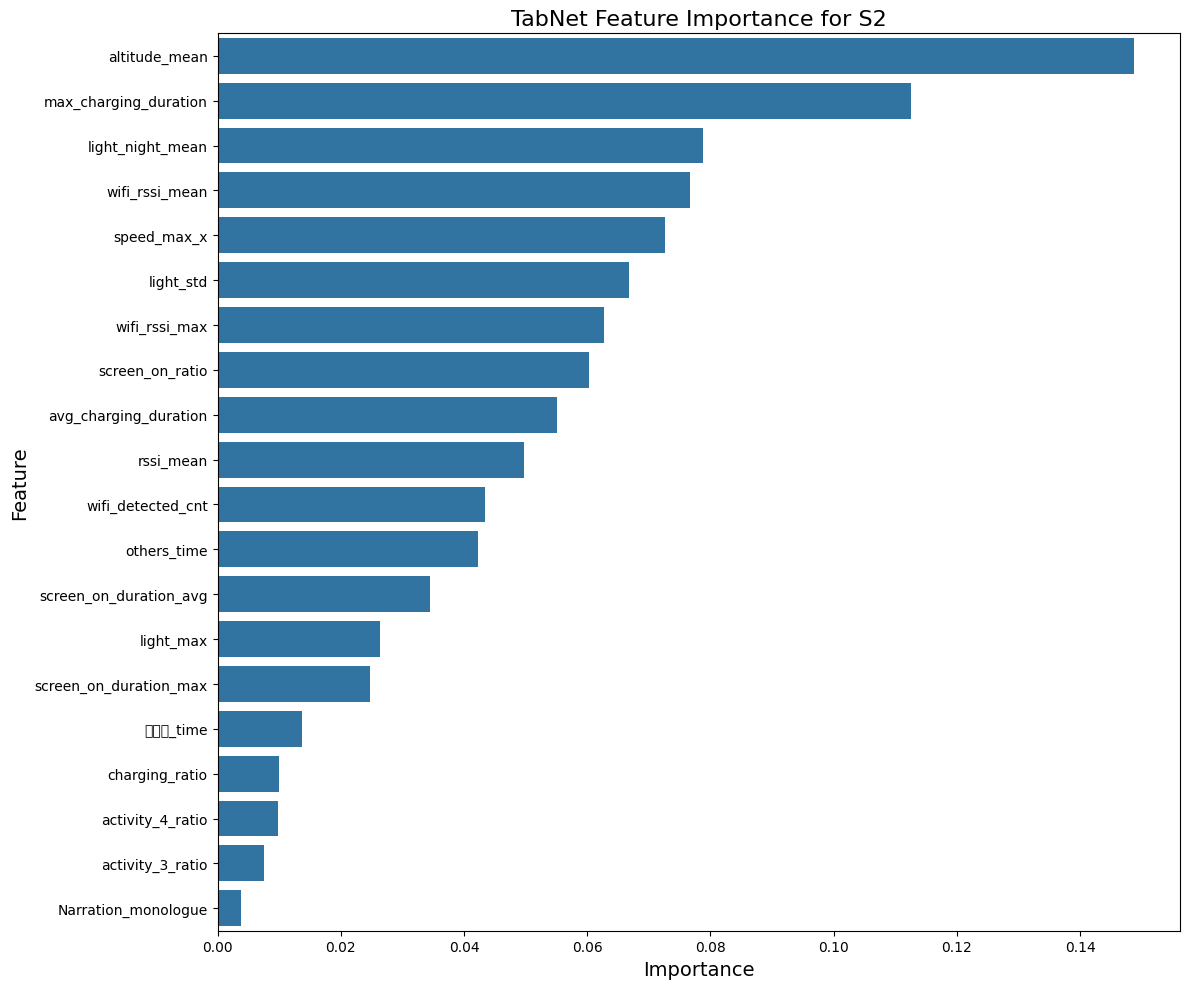

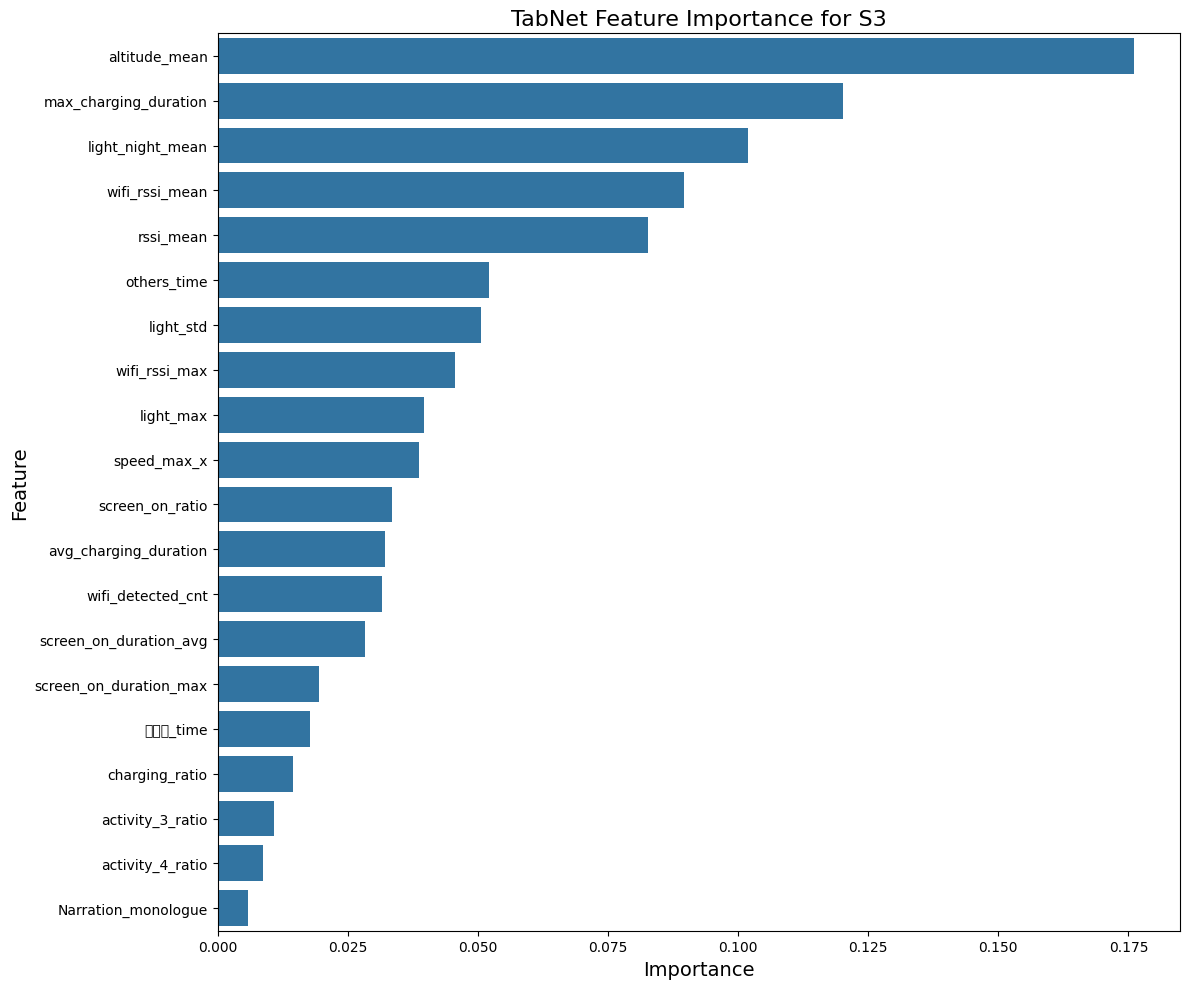

In [44]:
# feature-importance on Tabnet model
# 선택된 특성으로 모델 훈련
# 이진 분류
binary_preds_selected = {}
binary_models = {}  # 모델을 저장할 딕셔너리 추가

for col in targets_binary:
    y = train_df[col]

    # TabNetClassifier 초기화
    model = TabNetClassifier(**tabnet_params)

    # 모델 학습
    model.fit(
        X_selected.values,
        y,
        eval_set=[(X_selected.values, y)],
        eval_metric=['auc'],
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=128
    )
    
    # 모델 저장
    binary_models[col] = model

    # 예측
    probs = model.predict_proba(test_X_selected.values)
    binary_preds_selected[col] = (probs[:, 1] > 0.5).astype(int)

# 다중 분류 (S1)
y_multi = train_df['S1'].values

# TabNetClassifier 초기화
model_s1_selected = TabNetClassifier(**tabnet_params)

# 모델 학습
model_s1_selected.fit(
    X_selected.values,
    y_multi,
    eval_set=[(X_selected.values, y_multi)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

# 예측
multiclass_pred_selected = model_s1_selected.predict(test_X_selected.values)

# S1 모델의 특성 중요도 시각화
visualize_tabnet_feature_importance(
    model=model_s1_selected,
    feature_names=X_selected.columns.tolist(),
    k = "S1", 
    title="TabNet Feature Importance for S1 (Sleep Quality)"
)

# 각 이진 분류 모델의 특성 중요도 시각화
for col, model in binary_models.items():
    visualize_tabnet_feature_importance(
        model=model,
        feature_names=X_selected.columns.tolist(),
        k = f"{col}",
        title=f"TabNet Feature Importance for {col}"
    )
    

In [45]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [46]:

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred_selected) # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred_selected

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds_selected[col].astype(int) # 확률 아닌 class 예측


In [47]:

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

✅ 제출 파일이 저장되었습니다: /home/user/torch_ubuntu/lifelog-sleep-ictc-2025/minjeong/submission_final_mod2_1_0517_2310.csv


In [ ]:

# # 모델 저장 (추가 기능)
# import joblib

# # 모델 저장 디렉토리 생성
# os.makedirs('models', exist_ok=True)

# # 이진 분류 모델 저장
# for col in targets_binary:
#     joblib.dump(binary_preds[col], f'models/binary_model_{col}.pkl')
#     print(f"✅ 저장 완료: binary_model_{col}.pkl")

# # 다중 분류 모델 저장
# joblib.dump(model_s1, 'models/multiclass_model_S1.pkl')
# print(f"✅ 저장 완료: multiclass_model_S1.pkl")

✅ 저장 완료: binary_model_Q1.pkl
✅ 저장 완료: binary_model_Q2.pkl
✅ 저장 완료: binary_model_Q3.pkl
✅ 저장 완료: binary_model_S2.pkl
✅ 저장 완료: binary_model_S3.pkl
✅ 저장 완료: multiclass_model_S1.pkl


In [ ]:
 
# # 결과 요약 - 특성 중요도 상위 20개 표시
# print("\n===== 주요 특성 중요도 (상위 20개) =====")
# print(feature_importance.head(20))

# # 모델 평가 (검증 데이터가 있는 경우)
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # 검증용 데이터 분리
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )


===== 주요 특성 중요도 (상위 20개) =====
                   feature  importance
44         screen_on_ratio    0.021762
48             others_time    0.020832
46  screen_on_duration_avg    0.020828
7         activity_3_ratio    0.017365
62           wifi_rssi_max    0.016938
60          wifi_rssi_mean    0.016477
3    max_charging_duration    0.016160
26               rssi_mean    0.015765
0           charging_ratio    0.015758
8         activity_4_ratio    0.015606
41        light_night_mean    0.015580
47  screen_on_duration_max    0.015548
39               light_max    0.015141
2    avg_charging_duration    0.014409
31           altitude_mean    0.013876
38               light_std    0.013854
63       wifi_detected_cnt    0.013744
35             speed_max_x    0.013394
57                메시지_time    0.013303
19     Narration_monologue    0.013183


In [ ]:

# # 평가용 모델 학습
# eval_model = RandomForestClassifier(**common_params)
# eval_model.fit(X_train, y_train)

# # 예측 및 평가
# y_pred = eval_model.predict(X_val)
# print("\n===== 다중 분류 모델 평가 (S1) =====")
# print(classification_report(y_val, y_pred))


===== 다중 분류 모델 평가 (S1) =====
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        29
           1       0.52      0.84      0.64        45
           2       1.00      0.06      0.12        16

    accuracy                           0.51        90
   macro avg       0.65      0.38      0.36        90
weighted avg       0.58      0.51      0.44        90



In [ ]:

# # 이진 분류 모델 평가
# for col in targets_binary:
#     y_binary = train_df[col]
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
#     )
    
#     eval_model = RandomForestClassifier(**common_params)
#     eval_model.fit(X_train, y_train)
    
#     y_pred = eval_model.predict(X_val)
#     print(f"\n===== 이진 분류 모델 평가 ({col}) =====")
#     print(classification_report(y_val, y_pred))

# print("\n✅ 모든 과정이 완료되었습니다!")


===== 이진 분류 모델 평가 (Q1) =====
              precision    recall  f1-score   support

           0       0.59      0.58      0.58        45
           1       0.59      0.60      0.59        45

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.59      0.59      0.59        90


===== 이진 분류 모델 평가 (Q2) =====
              precision    recall  f1-score   support

           0       0.49      0.54      0.51        39
           1       0.62      0.57      0.59        51

    accuracy                           0.56        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.56      0.56        90


===== 이진 분류 모델 평가 (Q3) =====
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        36
           1       0.63      0.81      0.71        54

    accuracy                           0.60        90
   macro avg       0.56      0.55     